# Analyse exploratoire des donnees Camp Market

Ce carnet se concentre sur l'analyse exploratoire (EDA) des clients de Camp Market. L'objectif est de comprendre la structure du jeu de donnees, mettre en avant les tendances clefs et identifier les axes d'analyse pour les etapes de modelisation.

## Plan d'exploration

1. Charger le jeu de donnees et verifier sa structure.
2. Quantifier les valeurs manquantes et les ordres de grandeur.
3. Visualiser les distributions numeriques majeures.
4. Analyser les categories socio-demographiques et le comportement d'achat.
5. Evaluer les correlations et premieres relations business.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.set_option("display.precision", 2)
sns.set_theme(style="whitegrid", palette="deep")


In [2]:
# Chargement du jeu de donnees
file_path = "Camp_Market.csv"
df = pd.read_csv(file_path, sep=";", parse_dates=["Dt_Customer"])

print(f"Jeu de donnees charge : {df.shape[0]} lignes x {df.shape[1]} colonnes")
df.head()


Jeu de donnees charge : 2240 lignes x 29 colonnes


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [3]:
import io

buffer = io.StringIO()
df.info(buf=buffer)
info_str = buffer.getvalue()
print(info_str)

info_buffer = []
df.info(buf=info_buffer)
print("".join(info_buffer))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2240 non-null   int64         
 1   Year_Birth           2240 non-null   int64         
 2   Education            2240 non-null   object        
 3   Marital_Status       2240 non-null   object        
 4   Income               2216 non-null   float64       
 5   Kidhome              2240 non-null   int64         
 6   Teenhome             2240 non-null   int64         
 7   Dt_Customer          2240 non-null   datetime64[ns]
 8   Recency              2240 non-null   int64         
 9   MntWines             2240 non-null   int64         
 10  MntFruits            2240 non-null   int64         
 11  MntMeatProducts      2240 non-null   int64         
 12  MntFishProducts      2240 non-null   int64         
 13  MntSweetProducts     2240 non-nul

AttributeError: 'list' object has no attribute 'write'

In [ ]:
# Statistiques descriptives des variables numeriques
numeric_summary = df.select_dtypes(include=[np.number]).describe().T
numeric_summary


In [ ]:
# Statistiques descriptives des variables categorielle
categorical_summary = (
    df.select_dtypes(include="object")
      .describe()
      .T
)
categorical_summary


In [4]:
# Valeurs manquantes
missing = (
    df.isna()
      .sum()
      .to_frame(name="missing_count")
      .assign(missing_rate=lambda x: x["missing_count"] / len(df))
      .query("missing_count > 0")
      .sort_values("missing_count", ascending=False)
)
missing


,missing_count,missing_rate
Income,24,0.01


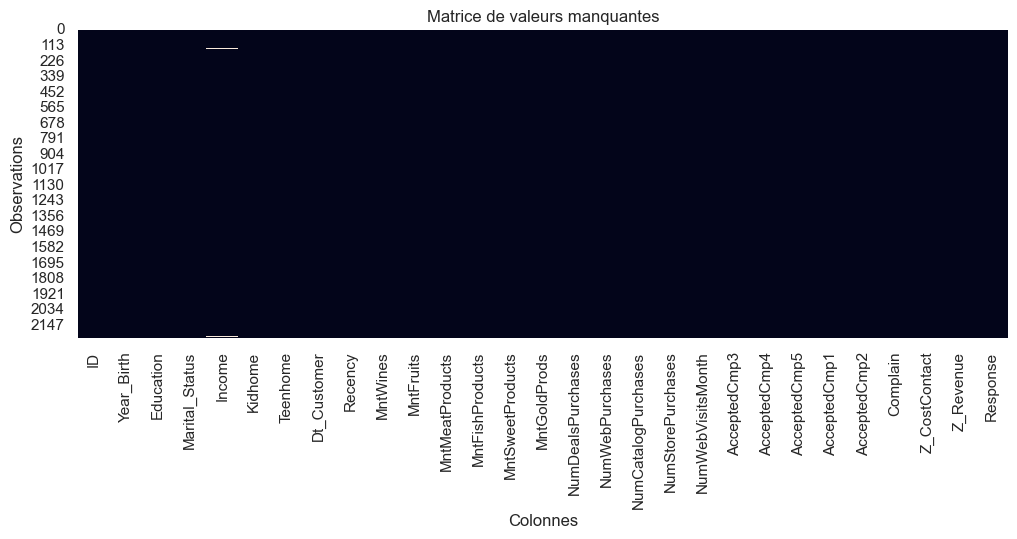

In [5]:
# Visualisation des valeurs manquantes
plt.figure(figsize=(12, 4))
sns.heatmap(df.isna(), cbar=False)
plt.title("Matrice de valeurs manquantes")
plt.xlabel("Colonnes")
plt.ylabel("Observations")
plt.show()


## Distributions numeriques

Les variables ci-dessous couvrent la capacite d'achat (`Income`), la recence des achats (`Recency`) et les depenses par familles de produits. Les distributions donnent un premier apercu de la variance et des valeurs extremes a surveiller.

In [ ]:
numeric_features = [
    "Income",
    "Recency",
    "MntWines",
    "MntMeatProducts",
    "MntGoldProds",
    "NumStorePurchases",
]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for col, ax in zip(numeric_features, axes.flatten()):
    sns.histplot(data=df, x=col, kde=True, ax=ax, bins=30)
    ax.set_title(col)

for ax in axes.flatten()[len(numeric_features):]:
    ax.remove()

fig.suptitle("Distributions de variables numeriques clefs", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
# Boxplots pour identifier les valeurs extremes
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
selected_box = ["Income", "Recency", "NumWebVisitsMonth"]
for col, ax in zip(selected_box, axes):
    sns.boxplot(data=df, y=col, ax=ax)
    ax.set_title(f"Distribution de {col}")
plt.tight_layout()
plt.show()


In [ ]:
# Depenses totales par famille de produits
spending_cols = [col for col in df.columns if col.startswith("Mnt")]
spending_totals = df[spending_cols].sum().sort_values(ascending=False)

print("Depense totale cumulee par categorie de produits:")
print(spending_totals)

plt.figure(figsize=(10, 5))
spending_totals.plot(kind="bar")
plt.title("Depenses cumulees par categorie de produits")
plt.ylabel("Montant total")
plt.tight_layout()
plt.show()


In [ ]:
# Analyse des canaux d'achat
channel_cols = [
    "NumWebPurchases",
    "NumCatalogPurchases",
    "NumStorePurchases",
    "NumDealsPurchases",
]

channel_means = df[channel_cols].mean().sort_values(ascending=False)
print("Nombre moyen d'achats par canal:")
print(channel_means)

plt.figure(figsize=(8, 4))
channel_means.plot(kind="bar")
plt.title("Moyenne des achats par canal")
plt.ylabel("Volume moyen")
plt.tight_layout()
plt.show()


## Profils categoriels

Les graphiques suivants comparent la repartition des categories sociodemographiques et la participation aux campagnes.

In [ ]:
categorical_cols = ["Marital_Status", "Education", "Response"]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for col, ax in zip(categorical_cols, axes):
    order = df[col].value_counts().index
    sns.countplot(data=df, x=col, order=order, ax=ax)
    ax.set_title(f"Repartition de {col}")
    ax.tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Taux d'acceptation des campagnes
campaign_cols = [col for col in df.columns if col.startswith("AcceptedCmp")]
campaign_cols += ["Response"]

acceptance_rate = df[campaign_cols].mean().sort_values(ascending=False)
acceptance_rate.to_frame(name="taux_acceptation")


In [ ]:
# Profil des repondants vs non-repondants
spending_cols = [col for col in df.columns if col.startswith("Mnt")]
df_profiles = df.assign(TotalSpend=df[spending_cols].sum(axis=1))

response_profile = (
    df_profiles.groupby("Response")
      .agg(
          clients=("ID", "count"),
          revenu_median=("Income", "median"),
          depense_totale_mediane=("TotalSpend", "median"),
          recence_moyenne=("Recency", "mean"),
          visites_web_moyennes=("NumWebVisitsMonth", "mean")
      )
      .rename(index={0: "Non", 1: "Oui"})
)
response_profile


## Relations et correlations

Nous examinons les dependances entre les variables numeriques pour identifier des groupes co-varients, utiles pour la segmentation.

In [ ]:
# Matrice de correlation sur un sous-ensemble numerique
cols_for_corr = [
    "Income",
    "Recency",
    "MntWines",
    "MntMeatProducts",
    "MntFishProducts",
    "MntSweetProducts",
    "MntGoldProds",
    "NumWebPurchases",
    "NumCatalogPurchases",
    "NumStorePurchases",
    "NumWebVisitsMonth"
]

corr_matrix = df[cols_for_corr].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Carte de correlations des indicateurs clefs")
plt.tight_layout()
plt.show()


In [ ]:
# Relation revenu vs depense totale
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=df_profiles,
    x="Income",
    y="TotalSpend",
    hue="Response",
    alpha=0.6
)
plt.title("Income vs depense totale selon la reponse a la campagne")
plt.tight_layout()
plt.show()


In [ ]:
# Age du client et anciennete dans le programme
current_year = pd.Timestamp.today().year
age = current_year - df["Year_Birth"]
anciennete = (pd.Timestamp.today() - df["Dt_Customer"]).dt.days / 365.25

plt.figure(figsize=(7, 5))
sns.scatterplot(x=age, y=anciennete, hue=df["Response"], alpha=0.6)
plt.title("Age vs anciennete dans le programme")
plt.xlabel("Age estime")
plt.ylabel("Anciennete (annees)")
plt.tight_layout()
plt.show()


## Points clefs a approfondir

- Les depenses sont fortement portees par les produits vins et viandes : a confirmer apres nettoyage.
- Le canal magasin domine en volume, mais les repondants semblent aussi plus actifs sur le web (a valider).
- La correlation entre depenses et income devra etre controlee et normalisee avant la modelisation.
- Explorer des segments education x statut marital permettra de cibler les campagnes futures.
- Une etude temporelle de `Dt_Customer` (cohorte, retours) pourrait enrichir l'analyse business.